In [1]:
import gshap
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import bernoulli, norm, uniform

In [2]:
N = 1000
x1 = norm(0, 1).rvs(N)
x2 = norm(0, 2).rvs(N)
X = np.array([x1, x2]).T
y = x1 + x2
reg = LinearRegression().fit(X, y)
print('Coef on x1: {:.2f}'.format(reg.coef_[0]))
print('Coef on x2: {:.2f}'.format(reg.coef_[1]))

Coef on x1: 1.00
Coef on x2: 1.00


In [3]:
X = StandardScaler().fit_transform(X)
reg = LinearRegression().fit(X, y)
print('Coef on x1: {:.2f}'.format(reg.coef_[0]))
print('Coef on x2: {:.2f}'.format(reg.coef_[1]))

Coef on x1: 1.02
Coef on x2: 1.99


<AxesSubplot:ylabel='Count'>

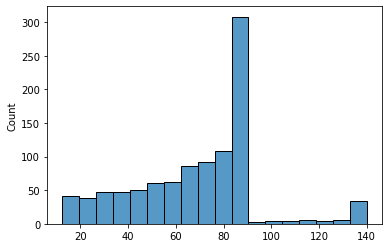

In [4]:
manager = bernoulli(.1).rvs(N)
socialize = uniform(2, 30).rvs(N)
X = np.array([manager, socialize, socialize**2]).T
y = 50 * manager + 6 * socialize - .1 * socialize**2
sns.histplot(y)

In [5]:
reg = LinearRegression().fit(X, y)
print('Coef on manager: {:.2f}'.format(reg.coef_[0]))
print('Coef on social: {:.2f}'.format(reg.coef_[1]))
print('Coef on social-squared: {:.2f}'.format(reg.coef_[2]))

Coef on manager: 50.00
Coef on social: 6.00
Coef on social-squared: -0.10


In [6]:
X = StandardScaler().fit_transform(X)
reg = LinearRegression().fit(X, y)
print('Coef on manager: {:.2f}'.format(reg.coef_[0]))
print('Coef on social: {:.2f}'.format(reg.coef_[1]))
print('Coef on social-squared: {:.2f}'.format(reg.coef_[2]))

Coef on manager: 13.64
Coef on social: 51.40
Coef on social-squared: -29.79


In [7]:
class Model(LinearRegression):
    def fit(self, X, y):
        return super().fit(self._transform(X), y)
        
    def predict(self, X):
        return super().predict(self._transform(X))
        
    def _transform(self, X):
        return np.append(X, (X[:,1]**2).reshape(-1, 1), axis=1)
    
X = np.array([manager, socialize]).T
reg = Model().fit(X, y)
g = lambda y_pred: y_pred
explainer = gshap.KernelExplainer(reg.predict, X, g)
gshap_values = explainer.gshap_values(X, nsamples=5000)

In [8]:
X_mean = np.mean(X, axis=0)
y_mean = y.mean()
y_pred = reg.predict(X)
print('Probability of being a manager: {:.2f}'.format(X_mean[0]))
print('Average hours of socializing: {:.2f}'.format(X_mean[1]))
print('Average extraversion score: {:.2f}'.format(y_mean))
for idx in range(10):
    print()
    print('Manger: {}'.format(X[idx][0]==1))
    print('Hours socializing: {:.2f}'.format(X[idx][1]))
    print('Predicted extraversion: {:.2f}'.format(y_pred[idx]))
    print('Explained by managerial status: {:.2f}'.format(gshap_values[0,idx]))
    print('Explained by socializing: {:.2f}'.format(gshap_values[1][idx]))
    print('Total prediction explained: {:.2f}'.format(gshap_values[:,idx].sum()))
    print('Total difference from average extraversion score: {:.2f}'.format(y_pred[idx]-y_mean))

Probability of being a manager: 0.08
Average hours of socializing: 16.83
Average extraversion score: 69.36

Manger: False
Hours socializing: 7.06
Predicted extraversion: 37.37
Explained by managerial status: -4.24
Explained by socializing: -27.47
Total prediction explained: -31.71
Total difference from average extraversion score: -31.99

Manger: True
Hours socializing: 5.19
Predicted extraversion: 78.46
Explained by managerial status: 45.84
Explained by socializing: -37.10
Total prediction explained: 8.74
Total difference from average extraversion score: 9.10

Manger: False
Hours socializing: 17.04
Predicted extraversion: 73.20
Explained by managerial status: -4.19
Explained by socializing: 7.60
Total prediction explained: 3.41
Total difference from average extraversion score: 3.83

Manger: False
Hours socializing: 13.13
Predicted extraversion: 61.55
Explained by managerial status: -4.31
Explained by socializing: -3.72
Total prediction explained: -8.03
Total difference from average ext

<AxesSubplot:>

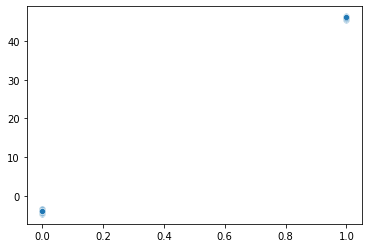

In [9]:
sns.scatterplot(x=manager, y=gshap_values[0])

<AxesSubplot:>

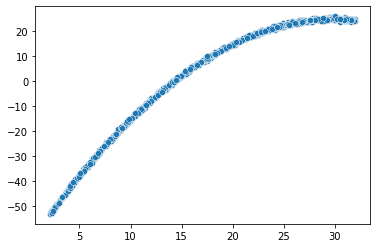

In [10]:
sns.scatterplot(x=socialize, y=gshap_values[1])

Importance of manager: 0.25
Importance of socialize: 0.75


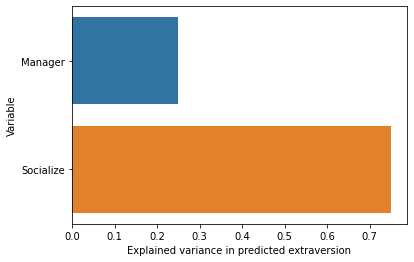

In [11]:
g = lambda y_pred: r2_score(y, y_pred)
explainer = gshap.KernelExplainer(reg.predict, X, g)
gshap_values = explainer.gshap_values(X, nsamples=100)
gshap_values /= gshap_values.sum()
df = pd.DataFrame({
    'Variable': ['Manager', 'Socialize'], 
    'Importance': list(gshap_values)
})
ax = sns.barplot(data=df, x='Importance', y='Variable')
ax.set(xlabel="Explained variance in predicted extraversion")
ax
print('Importance of manager: {:.2f}'.format(gshap_values[0]))
print('Importance of socialize: {:.2f}'.format(gshap_values[1]))

In [12]:
social_media = 0.5 * socialize + norm(0, 2).rvs(N)
y = 50 * manager + 6 * socialize - .1 * socialize**2 - social_media
corr = np.corrcoef(y, social_media)[0][1]
print('Correlation between extraversion and social media: {:.2f}'.format(corr))

Correlation between extraversion and social media: 0.65


In [13]:
X = np.array([manager, socialize, social_media]).T
reg = Model().fit(X, y)
print('Coef on social media: {:.2f}'.format(reg.coef_[-1]))

Coef on social media: -0.10


Importance of manager: -0.00
Importance of socialize: 0.78
Importance of social media: -0.12


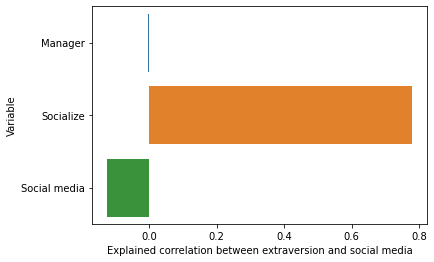

In [14]:
g = lambda y_pred: np.corrcoef(y_pred, social_media)[0][1]
explainer = gshap.KernelExplainer(reg.predict, X, g)
gshap_values = explainer.gshap_values(X, nsamples=100)
gshap_values *= corr / gshap_values.sum()
df = pd.DataFrame({
    'Variable': ['Manager', 'Socialize', 'Social media'], 
    'Importance': list(gshap_values)
})
ax = sns.barplot(data=df, x='Importance', y='Variable')
ax.set(xlabel='Explained correlation between extraversion and social media')
print('Importance of manager: {:.2f}'.format(gshap_values[0]))
print('Importance of socialize: {:.2f}'.format(gshap_values[1]))
print('Importance of social media: {:.2f}'.format(gshap_values[2]))